# import data

In [41]:
# Célula 1 - imports e leitura do ARFF
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import joblib
import seaborn as sns

# Lê o arquivo ARFF (assume que column_2C_weka.arff está no diretório atual)
data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

# Conversão automática de bytes para strings se necessário (pandas lê ARFF com bytes em alguns campos)
for col in df.select_dtypes([object]).columns:
    try:
        df[col] = df[col].str.decode('utf-8')
    except Exception:
        pass

print("Dimensão do dataset:", df.shape)
df.head()

Dimensão do dataset: (310, 7)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [42]:
# - estatísticas descritivas e inspeção
print("Tipos das colunas:\n", df.dtypes)
print("\nResumo estatístico (numérico):")
display(df.describe(include='all'))

if df.columns[-1].lower().startswith('class') or df.columns[-1].lower() in ['class', 'status', 'result', 'consequence', 'outcome', 'type']:
    class_col = df.columns[-1]
else:
   
    class_col = df.columns[-1]

print(f"\nColuna de classe assumida: '{class_col}'")
print(df[class_col].value_counts())

Tipos das colunas:
 pelvic_incidence            float64
pelvic_tilt                 float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class                        object
dtype: object

Resumo estatístico (numérico):


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310
unique,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal
freq,NaN,NaN,NaN,NaN,NaN,NaN,210
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,NaN
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,NaN
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,NaN
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,NaN
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,NaN
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,NaN



Coluna de classe assumida: 'class'
class
Abnormal    210
Normal      100
Name: count, dtype: int64


In [43]:
# Limpeza básica
# Ponto 1
print("Missing por coluna:\n", df.isna().sum())

if df.isna().sum().sum() > 0:
    num_cols = df.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        df[c].fillna(df[c].median(), inplace=True)
    # para categóricas, preencha com moda
    cat_cols = df.select_dtypes(include=['object']).columns
    for c in cat_cols:
        df[c].fillna(df[c].mode()[0], inplace=True)

# duplicatas
dups = df.duplicated().sum()
print(f"Linhas duplicadas: {dups}")
if dups > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicatas removidas. Novo shape:", df.shape)

Missing por coluna:
 pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64
Linhas duplicadas: 0


In [44]:
# Ponto 2
le = LabelEncoder()
y = le.fit_transform(df[class_col])
print("Classes (label encoder):", list(le.classes_))

X = df.drop(columns=[class_col]).copy()

non_num = X.select_dtypes(exclude=[np.number]).columns.tolist()
if len(non_num) > 0:
    print("Colunas não-numéricas encontradas e transformadas:", non_num)
    X = pd.get_dummies(X, columns=non_num, drop_first=True)

num_cols = X.select_dtypes(include=[np.number]).columns
if len(num_cols) >= 2:
    X['sum_features'] = X[num_cols].sum(axis=1)
    X['mean_features'] = X[num_cols].mean(axis=1)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Novo shape X:", X_scaled.shape)
X_scaled.head()

Classes (label encoder): ['Abnormal', 'Normal']
Novo shape X: (310, 8)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,sum_features,mean_features
0,0.147086,0.501369,-0.665177,-0.184950,-1.447647,-0.708059,-0.678049,-0.678049
1,-1.245864,-0.748769,-1.453001,-1.041521,-0.264385,-0.579556,-1.214580,-1.214580
2,0.484370,0.467932,-0.099262,0.273083,-0.897686,-0.795421,-0.344154,-0.344154
3,0.511390,0.711562,-0.411339,0.126128,-1.207303,-0.402288,-0.270363,-0.270363
4,-0.626648,-0.789693,-1.274745,-0.215876,-0.733455,-0.490106,-0.936868,-0.936868


In [45]:
Xr = X_scaled.copy()
yr = y.copy()


Q1 = Xr.quantile(0.25)
Q3 = Xr.quantile(0.75)
IQR = Q3 - Q1
mask = ~((Xr < (Q1 - 1.5 * IQR)) | (Xr > (Q3 + 1.5 * IQR))).any(axis=1)

print(f"Linhas originais: {Xr.shape[0]}  - Linhas após remoção de outliers: {mask.sum()}")
Xr = Xr[mask].reset_index(drop=True)
yr = yr[mask]

unique, counts = np.unique(yr, return_counts=True)
print("Contagem por classe após limpeza:", dict(zip(unique, counts)))

Linhas originais: 310  - Linhas após remoção de outliers: 279
Contagem por classe após limpeza: {np.int64(0): np.int64(180), np.int64(1): np.int64(99)}


In [46]:
# Ponto 3 - split em treino/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(Xr, yr, test_size=0.20, stratify=yr, random_state=42)
# Separação de 75% treino, 25% val para resultar 60/20/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

print("Shapes -> treino, validacao, teste:", X_train.shape, X_val.shape, X_test.shape)

Shapes -> treino, validacao, teste: (167, 8) (56, 8) (56, 8)


In [47]:
# treino do RandomForest e avaliação na validação
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Avalia enquanto valida
y_val_pred = clf.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
print(f"Acurácia no conjunto de validação: {acc_val:.4f}")

Acurácia no conjunto de validação: 0.8571


Acurácia no conjunto de teste: 0.7857


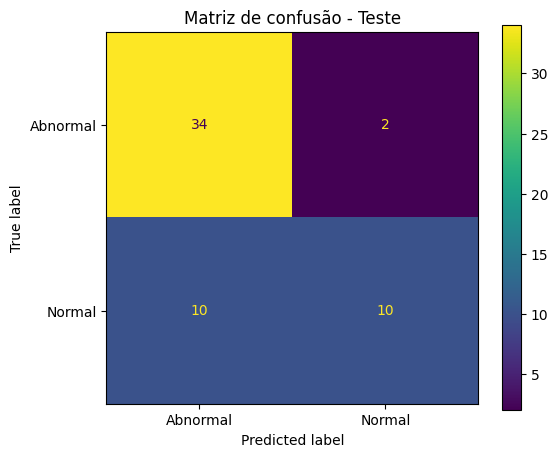

In [48]:
# Avaliação no teste geral.
y_test_pred = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Acurácia no conjunto de teste: {acc_test:.4f}")

# Matriz de confusão (plot)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax)
plt.title("Matriz de confusão - Teste")
plt.show()

In [49]:
# Célula 9 - métricas extras (opcional)
from sklearn.metrics import classification_report
print("Classification Report (Teste):\n")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

Classification Report (Teste):

              precision    recall  f1-score   support

    Abnormal       0.77      0.94      0.85        36
      Normal       0.83      0.50      0.62        20

    accuracy                           0.79        56
   macro avg       0.80      0.72      0.74        56
weighted avg       0.79      0.79      0.77        56



In [50]:
# Célula 10 - predição de exemplo
# Pega a primeira linha do conjunto de teste como exemplo
example_X = X_test.iloc[[0]]
example_true = y_test[0]
example_pred = clf.predict(example_X)[0]
print("Exemplo - valores (escalados):")
display(example_X)
print("Classe verdadeira (cod):", example_true, "->", le.inverse_transform([example_true])[0])
print("Classe predita (cod):", example_pred, "->", le.inverse_transform([example_pred])[0])

Exemplo - valores (escalados):


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,sum_features,mean_features
170,0.834336,-0.363658,0.58099,1.34251,-0.20397,0.183356,0.55771,0.55771


Classe verdadeira (cod): 0 -> Abnormal
Classe predita (cod): 0 -> Abnormal


In [51]:
#  salvar modelo e scaler
joblib.dump(clf, "model_random_forest.joblib")
joblib.dump(scaler, "scaler_standard.joblib")
print("Modelo e scaler salvos: model_random_forest.joblib, scaler_standard.joblib")

Modelo e scaler salvos: model_random_forest.joblib, scaler_standard.joblib


In [52]:
# resumo final
print("Resumo:")
print(f"Dataset final após limpeza: {Xr.shape}")
print(f"Acurácia (val): {acc_val:.4f} | Acurácia (test): {acc_test:.4f}")
print("Modelos e arquivos salvos na raiz do notebook.")

Resumo:
Dataset final após limpeza: (279, 8)
Acurácia (val): 0.8571 | Acurácia (test): 0.7857
Modelos e arquivos salvos na raiz do notebook.
